# Heartbeat disease classifier

In [1]:
# Pandas
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle

# Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping

# Audio
import librosa
import librosa.display

# Plot
import matplotlib.pyplot as plt

# Utility
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools

Using TensorFlow backend.


### Build Dataset

In [2]:
%%time
dataset = []
for folder in ["../input/set_a/**","../input/set_b/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            # skip audio smaller than 5 secs
            if librosa.get_duration(filename=filename)>=5:
                if label not in ["Aunlabelledtest", "Bunlabelledtest"]:
                    dataset.append({
                        "filename": filename,
                        "label": label
                    })
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)

CPU times: user 92 ms, sys: 116 ms, total: 208 ms
Wall time: 1.23 s


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350 entries, 157 to 102
Data columns (total 2 columns):
filename    350 non-null object
label       350 non-null object
dtypes: object(2)
memory usage: 8.2+ KB


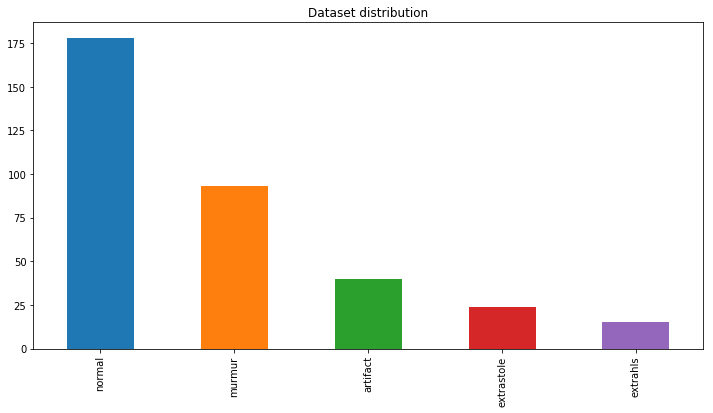

In [4]:
plt.figure(figsize=(12,6))
dataset.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show()

### Split dataset in train and test

In [5]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 280
Test: 70


In [6]:
train.label.unique()

array(['murmur', 'extrastole', 'normal', 'artifact', 'extrahls'],
      dtype=object)

### Show Audio info

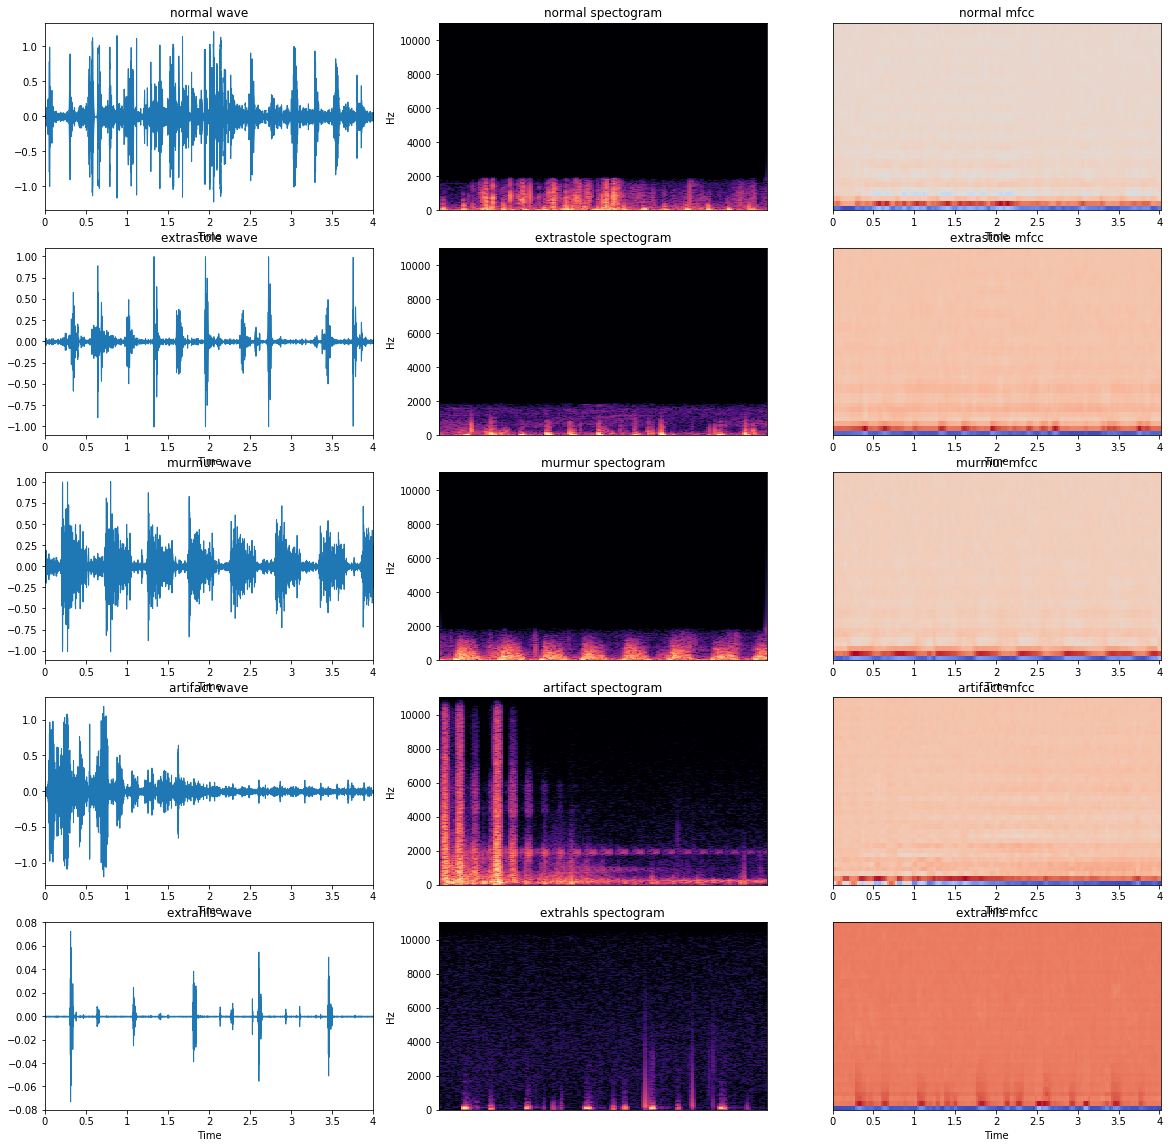

CPU times: user 4.65 s, sys: 1.81 s, total: 6.46 s
Wall time: 4.14 s


In [7]:
%%time
plt.figure(figsize=(20,20))
idx = 0
for label in dataset.label.unique():    
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[0], duration=4)
    idx+=1
    plt.subplot(5, 3, idx)
    plt.title("%s wave" % label)
    librosa.display.waveplot(y, sr=sr)
    idx+=1
    plt.subplot(5, 3, idx)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, y_axis='linear')
    plt.title("%s spectogram" % label)
    idx+=1
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    plt.subplot(5, 3, idx)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title("%s mfcc" % label)
plt.show()


### Extract features from audio

In [8]:
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, duration=4)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfccs

In [9]:
%%time
x_train, x_test = [], []
print("Extract features from TRAIN  and TEST dataset")
for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx]))
    
    
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

print("X train:", x_train.shape)
print("X test:", x_test.shape)

  0%|          | 0/280 [00:00<?, ?it/s]

Extract features from TRAIN  and TEST dataset


100%|██████████| 70/70 [00:09<00:00,  6.57it/s]

X train: (280, 40, 173)
X test: (70, 40, 173)
CPU times: user 58.8 s, sys: 29.3 s, total: 1min 28s
Wall time: 49 s


### Encode labels

In [10]:
%%time
encoder = LabelBinarizer()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.96 ms


### Input shapes

In [11]:

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)


print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print()
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (280, 40, 173, 1)
Y train: (280, 5)

X test: (70, 40, 173, 1)
Y test: (70, 5)


### Build Model

In [12]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 39, 172, 16)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 86, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_2 (Dropout)  

### Compile model

In [13]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

### Fit model

In [14]:
# define early stopping callback
earlystop = EarlyStopping(monitor='val_acc', min_delta=0.01, patience=5, verbose=1, mode='auto')
callbacks_list = [earlystop]

In [15]:
%%time
history = model.fit(x_train, y_train,
              batch_size=128,
              epochs=200,
              validation_data=(x_test, y_test),
              #callbacks=callbacks_list,
              shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 280 samples, validate on 70 samples
Epoch 1/200
280/280 [==============================] - 6s 21ms/step - loss: 8.8407 - acc: 0.3071 - val_loss: 4.4551 - val_acc: 0.5429
Epoch 2/200
280/280 [==============================] - 0s 169us/step - loss: 6.2380 - acc: 0.4214 - val_loss: 2.2906 - val_acc: 0.5714
Epoch 3/200
280/280 [==============================] - 0s 147us/step - loss: 5.6925 - acc: 0.3964 - val_loss: 2.9798 - val_acc: 0.5714
Epoch 4/200
280/280 [==============================] - 0s 135us/step - loss: 4.9145 - acc: 0.4786 - val_loss: 3.5671 - val_acc: 0.2286
Epoch 5/200
280/280 [==============================] - 0s 137us/step - loss: 5.3666 - acc: 0.3964 - val_loss: 2.3979 - val_acc: 0.6286
Epoch 6/200
280/280 [==============================] - 0s 146us/step - loss: 4.0894 - acc: 0.5000 - val_loss: 2.3881 - val_acc: 0.6143
Epoch 7/200
280/280 [==============================] - 0s 135us/step - loss: 3.6903 - acc: 0.5321 

Text(0.5, 1.0, 'Accuracy Curves')

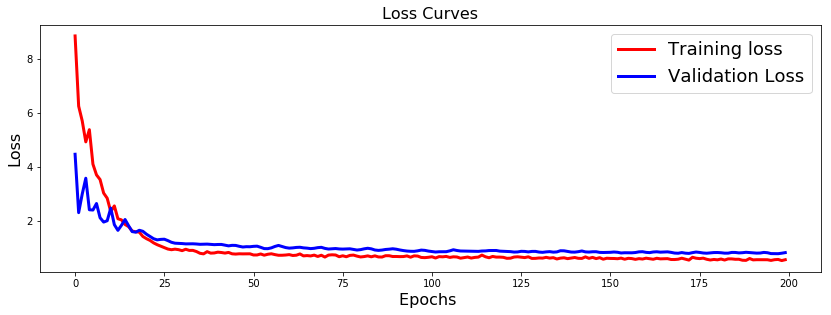

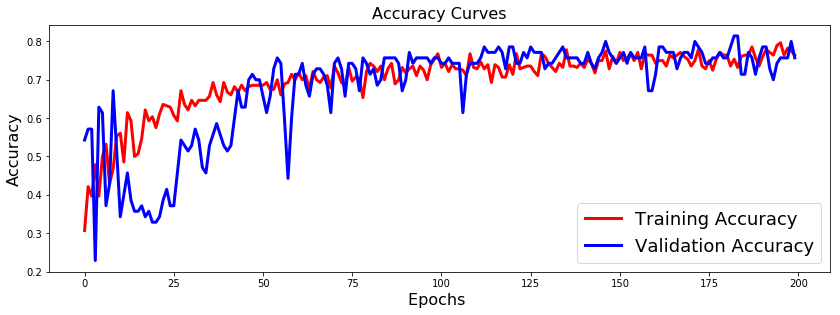

In [16]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

### Save model

In [17]:
# Save model and weights
model_name = "heartbeat_disease.h5"
model.save(model_name)
print('Saved trained model at %s ' % model_name)

Saved trained model at heartbeat_disease.h5 


### Evaluate model

In [18]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

70/70 [==============================] - 0s 325us/step
Test loss: 0.8099562951496669
Test accuracy: 0.7571428571428571


### Classification Report

In [19]:
predictions = model.predict(x_test, verbose=1)

70/70 [==============================] - 0s 1ms/step


In [20]:
y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])

In [21]:
print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

    artifact       0.83      0.62      0.71         8
    extrahls       0.80      0.67      0.73         6
  extrastole       0.67      0.67      0.67         6
      murmur       0.67      0.77      0.71        13
      normal       0.79      0.81      0.80        37

   micro avg       0.76      0.76      0.76        70
   macro avg       0.75      0.71      0.72        70
weighted avg       0.76      0.76      0.76        70



### Confusion Matrix

In [22]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(11, 11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)
    plt.tight_layout()

    plt.show()

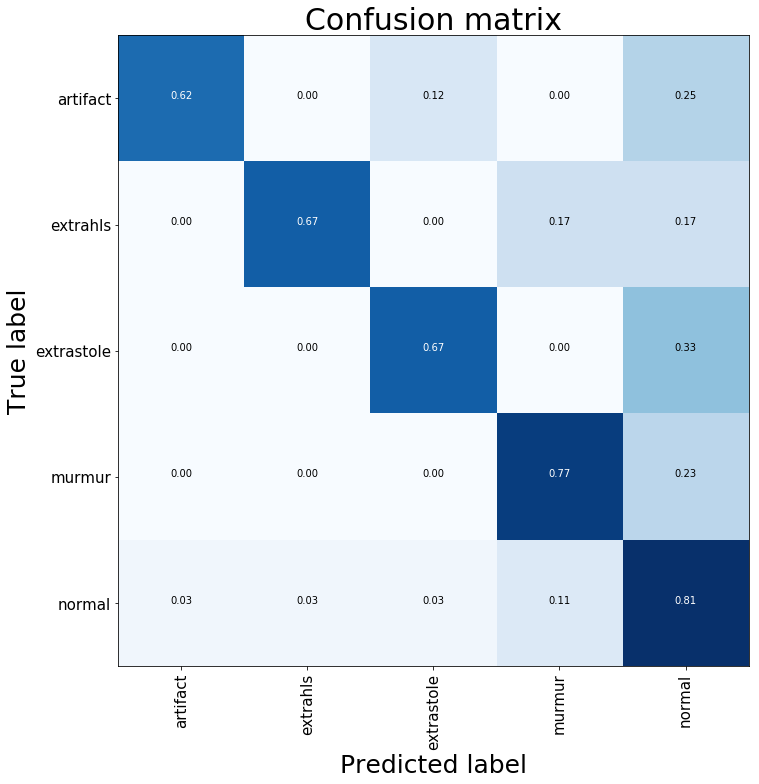

In [23]:
cnf_matrix = confusion_matrix(y_pred, y_true)
cnf_matrix = cnf_matrix.astype(float) / cnf_matrix.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cnf_matrix, classes)